# Ant Colony Optimization (ACO) for TSP

In this notebook, we will explore the Ant Colony Optimization (ACO) algorithm applied to the Traveling Salesman Problem (TSP). We'll explain its purpose, how it works, and demonstrate it using example TSP instances and visualizations.

##What is Ant Colony Optimization?
Ant Colony Optimization is a population-based, probabilistic optimization algorithm inspired by the foraging behavior of real ants. It is especially popular for combinatorial problems like TSP.

**Key points:**
  - Uses a colony of artificial “ants” to explore solutions.
  - Relies on pheromone trails and heuristic information (visibility) to guide search.
  - Stochastic: ants probabilistically choose paths based on pheromone intensity and distances.
  - Maintains a history of good solutions, gradually reinforcing better paths with more pheromone.

**Stops if:**
  - maximum generations are reached, or
  - convergence is achieved (paths no longer improve significantly).

**Notes:**
  - Well-suited for discrete combinatorial problems like TSP.
  - Evaporation prevents premature convergence to suboptimal solutions.
  Number of ants, pheromone evaporation rate, and number of generations are key parameters.

## How Ant Colony Optimization works

1. Initialize:
  - Set the number of ants, generations, and pheromone matrix.
  - Precompute the distance matrix between cities.

2. For each generation:
  - Compute visibility (inverse of distance) between cities.
  - Each ant constructs a path:
    - Start at a random city.
    - Probabilistically select the next city based on pheromone intensity and visibility.
    - Repeat until all cities are visited, then return to the start.
  - Evaluate all ants’ paths and record the best one.
  - Evaporate pheromone to reduce influence of old paths.
  - pdate pheromone on edges used by ants, reinforcing better paths.

3. Record the best path for each generation for analysis or visualization.
4. Optionally animate the evolution of paths over generations.

## How does Ant colony look?
You can check the implementation here or inside 'src/algorithms/ant_colony.py'.

```python
class AntColony:
    """
    Ant Colony Optimization (ACO) algorithm for the Traveling Salesman Problem (TSP).

    Attributes:
        cities (np.ndarray): Coordinates of cities, shape (n_cities, 2).
        n_ants (int): Number of ants in the colony.
        generations (int): Number of iterations (generations).
        evaporation_rate (float): Rate at which pheromone evaporates.
        pheromone_matrix (np.ndarray): Matrix of pheromone levels between cities.
        history (list): List of best paths found per generation.
    """

    def __init__(
            self,
            cities,
            n_ants=20,
            generations=100,
            evaporation_rate=0.5
        ):
        """
        Initialize the Ant Colony Optimization algorithm.

        Args:
            cities (np.ndarray): Array of city coordinates, shape (n_cities, 2).
            n_ants (int, optional): Number of ants (default=20).
            generations (int, optional): Number of generations (default=100).
            evaporation_rate (float, optional): Pheromone evaporation rate (default=0.5).
        """
        self.cities = cities
        self.n_ants = n_ants
        self.generations = generations
        self.evaporation_rate = evaporation_rate

        # Precompute matrices
        self.distance_matrix = self._compute_distance_matrix()
        self.pheromone_matrix = np.ones_like(self.distance_matrix)

        # Store history of best paths
        self.history = []

    def _compute_distance_matrix(self):
        """Compute symmetric distance matrix between all cities."""
        n = len(self.cities)
        matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i + 1, n):
                distance = TSPUtils.calculate_distance(self.cities[i], self.cities[j])
                matrix[i, j] = matrix[j, i] = distance
        return matrix

    def _compute_visibility(self):
        """Compute inverse of distance matrix (visibility)."""
        with np.errstate(divide='ignore', invalid='ignore'):
            visibility = np.divide(1.0, self.distance_matrix, where=self.distance_matrix != 0)
        np.fill_diagonal(visibility, 0)
        return visibility

    @staticmethod
    def _get_best_path(cities, ants):
        """Return the best path (lowest distance) among all ants."""
        def indices_to_path(idxs):
            return np.array([cities[i] for i in idxs])

        best_path = indices_to_path(ants[0])
        best_distance = TSPUtils.evaluate_individual(best_path)

        for ant in ants[1:]:
            path = indices_to_path(ant)
            distance = TSPUtils.evaluate_individual(path)
            if distance < best_distance:
                best_path, best_distance = path, distance

        return best_path

    @staticmethod
    def _select_next_city(current_city, unvisited, pheromone, visibility):
        """
        Select next city probabilistically based on pheromone and visibility.
        """
        pheromone_values = np.array([pheromone[current_city][c] for c in unvisited])
        visibility_values = np.array([visibility[current_city][c] for c in unvisited])
        weights = pheromone_values * (visibility_values ** 2)

        # Normalize to probabilities
        if np.sum(weights) == 0:
            return random.choice(list(unvisited))
        probabilities = weights / np.sum(weights)
        return random.choices(list(unvisited), weights=probabilities)[0]


    def run(self, animate_fn=None, animation_path=None):
        """
        Run the Ant Colony Optimization algorithm.

        Args:
            animate_fn (callable, optional): Animation callback.
            animation_path (str, optional): Path to save animation.

        Returns:
            list[np.ndarray]: History of best paths per generation.
        """
        n_cities = len(self.cities)

        for gen in range(self.generations):
            visibility = self._compute_visibility()
            ants = []

            # Each ant builds a path
            for _ in range(self.n_ants):
                start = random.randint(0, n_cities - 1)
                path = [start]
                unvisited = set(range(n_cities)) - {start}

                while unvisited:
                    current = path[-1]
                    next_city = self._select_next_city(current, unvisited, self.pheromone_matrix, visibility)
                    path.append(next_city)
                    unvisited.remove(next_city)

                # Return to start city
                path.append(start)
                ants.append(path)

            # Evaluate and record best path
            best_path = self._get_best_path(self.cities, ants)
            best_distance = TSPUtils.evaluate_individual(best_path)
            self.history.append(best_path)

            # Evaporate pheromones
            self.pheromone_matrix *= (1 - self.evaporation_rate)

            # Update pheromones
            for ant in ants:
                path_distance = TSPUtils.evaluate_individual(np.array([self.cities[i] for i in ant]))
                for i in range(len(ant) - 1):
                    a, b = ant[i], ant[i + 1]
                    delta = 1 / path_distance
                    self.pheromone_matrix[a, b] += delta
                    self.pheromone_matrix[b, a] += delta

            print(
                f"Generation {gen + 1}/{self.generations}, "
                f"Best Path Distance: {best_distance:.2f}"
            )

        # Optionally animate results
        if animate_fn and animation_path:
            animate_fn(self.history, self.cities, "Ant Colony Optimization", animation_path)

        return self.history


## Visualization
Next, we will visualize the Hill Climbing algorithm using the following benchmark functions:

- Sphere
- Ackley
- Rastrigin
- Rosenbrock
- Griewank
- Schwefel
- Lévy
- Michalewicz
- Zakharov

For more details about these functions and their implementations, please refer to the `test_functions.ipynb` notebook or check the `src/functions.py` file.

In [1]:
from src.tsp_utils import TSPUtils
from src.tsp_animator import TSPAnimator
from src.algorithms.ant_colony import AntColony

def run():
    """
    Run the Genetic Algorithm on the Traveling Salesman Problem (TSP)
    and visualize the optimization process.
    """
    # Parameters
    cities = 20
    population = 20
    generations = 200

    # Initialize problem
    generated = TSPUtils.generate_cities(cities)
    algorithm = AntColony(generated, population, generations)
    history = algorithm.run()

    # Visualize results
    animator = TSPAnimator(generated, history, algorithm_name="AntColony", output_dir="../assets/AntColony/")
    animator.save()


run()

Generation 1/200, Best Path Distance: 466.41
Generation 2/200, Best Path Distance: 543.57
Generation 3/200, Best Path Distance: 549.19
Generation 4/200, Best Path Distance: 519.91
Generation 5/200, Best Path Distance: 539.07
Generation 6/200, Best Path Distance: 467.83
Generation 7/200, Best Path Distance: 475.12
Generation 8/200, Best Path Distance: 513.23
Generation 9/200, Best Path Distance: 454.27
Generation 10/200, Best Path Distance: 455.71
Generation 11/200, Best Path Distance: 432.15
Generation 12/200, Best Path Distance: 412.41
Generation 13/200, Best Path Distance: 406.04
Generation 14/200, Best Path Distance: 421.10
Generation 15/200, Best Path Distance: 412.30
Generation 16/200, Best Path Distance: 422.51
Generation 17/200, Best Path Distance: 416.00
Generation 18/200, Best Path Distance: 405.29
Generation 19/200, Best Path Distance: 416.92
Generation 20/200, Best Path Distance: 412.88
Generation 21/200, Best Path Distance: 420.60
Generation 22/200, Best Path Distance: 413.

### Optimization Animation

Here is the Hill climbing process visualized:

<table>
<tr>
  <td><img src="../assets/AntColony/tsp_0.gif" width="1000"/></td>
</tr>
</table>
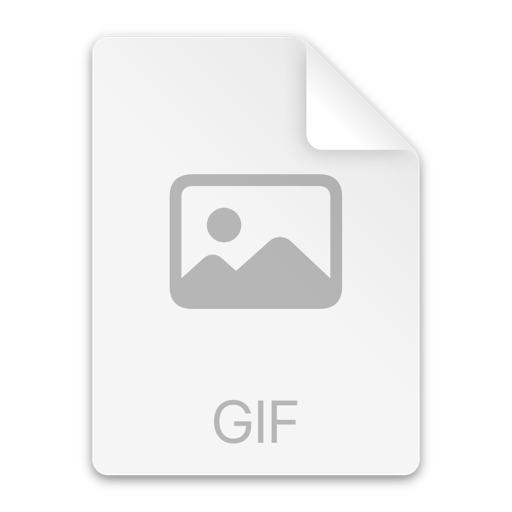
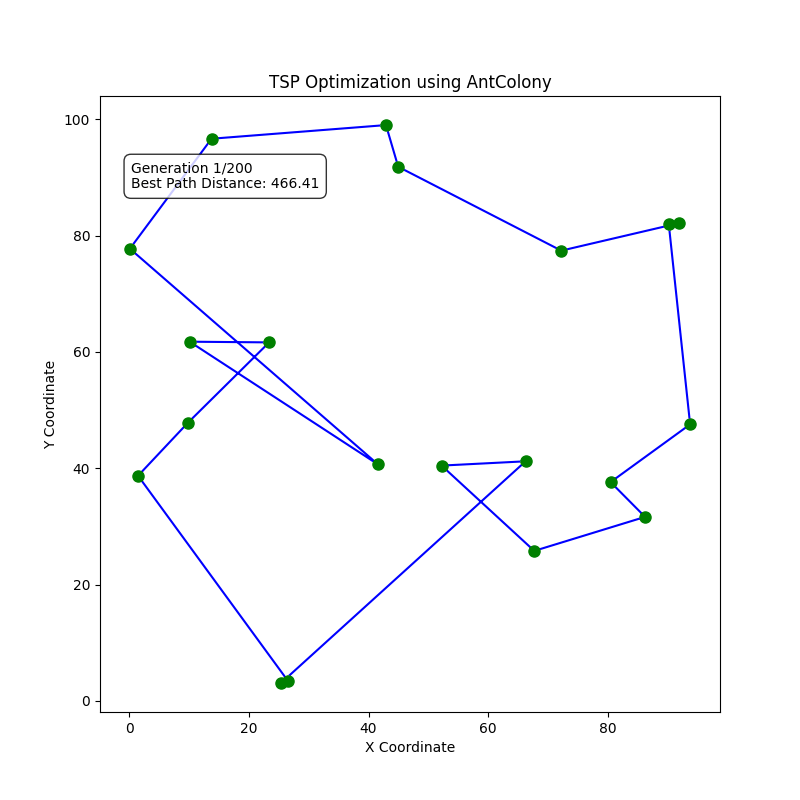
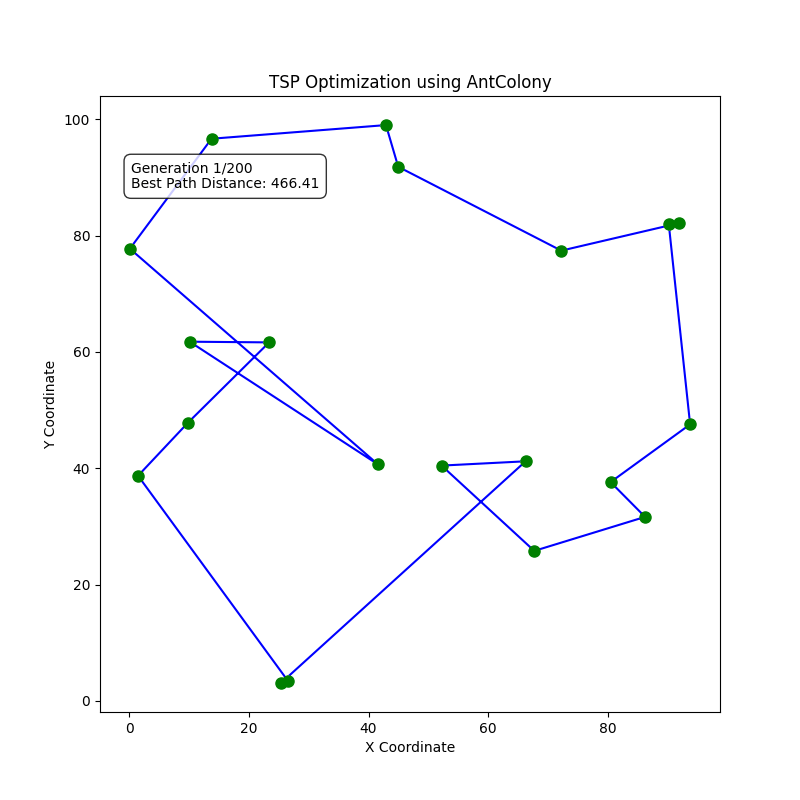

## Summary
- ACO is a population-based, probabilistic algorithm inspired by ant foraging behavior.
- Effective for discrete combinatorial problems like TSP, where solutions are sequences or permutations.
- Balances exploration (randomness) and exploitation (pheromone trails) to find short paths.
- Key parameters include number of ants, generations, and pheromone evaporation rate.
- Visualization of the best paths per generation helps understand convergence behavior and performance.